# Polarstern overflights
During the ACLOUD/PASCAL campaign, overflights of the Polar aircraft across research vessel Polarstern have been conducted. The following example shows, how to work with Polarstern overflights easily.

```{image} ../img/polarstern_acloud_pascal.jpg
:alt: Polarstern
:class: bg-primary mb-1
:width: 400px
:align: center
```

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import ipyleaflet
from ipywidgets import interact, widgets, Layout
from simplification.cutil import simplify_coords_idx
import ac3airborne
plt.style.use("../mplstyle/book")

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# local caching
kwds = {'simplecache': dict(
    cache_storage=os.environ['INTAKE_CACHE'], 
    same_names=True
)}

At first we load the flight-phase separation and the intake catalog.

In [2]:
meta = ac3airborne.get_flight_segments()
cat = ac3airborne.get_intake_catalog()

## Track of Polarstern during PASCAL
### Read data
The track of Polarstern is available on the PANGAEA data base with a resolution of 1 second. More information about the dataset can be found in 
[Macke et al. (2017)](https://doi.org/10.1594/PANGAEA.881579).
We import the dataset using the ac3airborne intake-catalog. 

In [3]:
ds_pol = cat['ACLOUD']['Polarstern']['TRACK']['PASCAL'].read().set_index('time').to_xarray()
ds_pol

<xarray.Dataset>
Dimensions:  (time: 2412000)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-24T10:00:01 ... 2017-06-21T08:00:00
Data variables:
    lat      (time) float64 53.57 53.57 53.57 53.57 ... 78.23 78.23 78.23 78.23
    lon      (time) float64 8.555 8.555 8.555 8.555 ... 15.65 15.65 15.65 15.65

### Plot Polarstern track
To get an overview of the track during the PASCAL campaign, we plot the Polarstern track on interactive map. The campaign took place from 2017-05-24 (start in Bremerhaven) to 2017-06-21 (end in Longyearbyen).

In [4]:
dates = pd.date_range('2017-05-24', '2017-06-21', freq='1D').date

In [5]:
def simplify_dataset(ds, tolerance):
    indices_to_take = simplify_coords_idx(np.stack([ds.lat.values, ds.lon.values], axis=1), tolerance)
    return ds.isel(time=indices_to_take)

In [6]:
# define colors for each day
colors = [mcolors.to_hex(c)
          for c in plt.cm.inferno(np.linspace(0, 1, len(dates)))]

In [7]:
m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Esri.NatGeoWorldMap,
                   center=(80., 6), zoom=3,
                   scroll_wheel_zoom=True)

for date, color in zip(dates, colors):
        
    # reduce dataset for plotting
    ds_reduced = simplify_dataset(ds_pol.sel(time=str(date)), tolerance=1e-5)
    
    track = ipyleaflet.Polyline(
        locations=np.stack([ds_reduced.lat.values, 
                            ds_reduced.lon.values], axis=1).tolist(), 
        color=color,
        fill=False,
        weight=2,
        name=str(date))
    
    m.add_layer(track)
    
m.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())
display(m)

Map(center=[80.0, 6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

## Flights near Polarstern
With the `flight-phase-separation`, we can easily work with Polarstern overflights. At first we list all flights, which contain a co-location between Polar5 and Polarstern within 15 km.

In [8]:
for flight_id, flight in meta['ACLOUD']['P5'].items():
        
    polarstern_remark = [event for event in flight['events'] 
                         if 'Polarstern' in event]
    
    if len(polarstern_remark) > 0:
        print(f'{flight_id}: {polarstern_remark}')

ACLOUD_P5_RF10: ['Polarstern overflight with racetrack pattern']
ACLOUD_P5_RF11: ['Polarstern overflight with cross pattern']
ACLOUD_P5_RF13: ['Polarstern overflight with cross pattern']
ACLOUD_P5_RF14: ['Polarstern overflight with cross pattern']
ACLOUD_P5_RF17: ['Polarstern overflight with racetrack pattern']
ACLOUD_P5_RF18: ['Polarstern overflight with cross pattern']
ACLOUD_P5_RF20: ['Polarstern overflight with cross pattern']
ACLOUD_P5_RF21: ['Polarstern overflight with cross pattern']


## Segments near Polarstern
Similarly, we can find the individual segments, which were within 15 km of the research vessel Polarstern.

In [9]:
for flight_id, flight in meta['ACLOUD']['P5'].items():
    
    polarstern_segment_id = [seg['segment_id'] for seg in flight['segments']
                         if seg.get('kinds') is not None
                         if 'polarstern_overflight' in seg['kinds']]
    
    if len(polarstern_segment_id) > 0:
        segments = ', '.join([seg.split('_')[-1] for seg in polarstern_segment_id])
        print(f'{flight_id}: {segments}')

ACLOUD_P5_RF10: ll12, rt01, la01
ACLOUD_P5_RF11: hl06, hl07, cr02, hl08
ACLOUD_P5_RF13: hl02, cr01, ld01, ll01
ACLOUD_P5_RF14: hl05, cr01, ld01, la01
ACLOUD_P5_RF17: ld01, ll01, ll02, ll03, ll04, ll05, rt01, ll06
ACLOUD_P5_RF18: hl02, hl03, cr01
ACLOUD_P5_RF20: cr01, ho01, la01
ACLOUD_P5_RF21: ld02, ll06, ll07, ll08, ll09, sa04, ll10, ll11, ll12, la02, cr01


## Flight duration near Polarstern
To calculate the distance in km between the aircraft and Polarstern, we project the coordinates into the UTM 33N reference system. Then, we can calculate the distance for each time step. 

In [10]:
def dist2polarstern(ds_gps, ds_pol):
    """
    Calculate distance of aircraft to Polarstern in
    UTM 33 coordinates
    """
    
    # read coordinate systems
    crs_g = ccrs.PlateCarree()
    crs_p = ccrs.UTM(zone='33')

    # aircraft: geographic --> projected
    aircraft_g = np.stack([ds_gps.lon.values,
                           ds_gps.lat.values], axis=1)
    ix = ~np.isnan(aircraft_g).any(axis=1)
    aircraft_g = aircraft_g[ix, :]
    aircraft_p = crs_p.transform_points(x=aircraft_g[:, 0], 
                                        y=aircraft_g[:, 1], 
                                        src_crs=crs_g)
    
            
    # polarstern: geographic --> projected
    ds_pol = ds_pol.sel(time=ds_gps.time[ix])
    polarstern_g = np.stack([ds_pol.lon.values,
                             ds_pol.lat.values], axis=1)
    polarstern_p = crs_p.transform_points(x=polarstern_g[:, 0], 
                                          y=polarstern_g[:, 1], 
                                          src_crs=crs_g)
    
    # distance between polarstern and aircraft in km
    d = np.linalg.norm(aircraft_p-polarstern_p, axis=1) * 1e-3
    
    ds = xr.Dataset()
    ds['time'] = ds_gps.time[ix].values
    ds['dist'] = (('time'), d)
    
    return ds

In [11]:
flights_polarstern = np.array([])
times_polarstern = np.array([])

for flight_id, flight in meta['ACLOUD']['P5'].items():
    
    # skip dates before and after polarstern cruise
    if flight['date'] not in dates:
        continue
    
    # read gps data of flight
    ds_gps = cat['ACLOUD']['P5']['GPS_INS'][flight_id].to_dask()
    
    # calculate distance to Polarstern
    ds_dist = dist2polarstern(ds_gps, ds_pol.sel(time=ds_gps.time))

    if ds_dist['dist'].min() < 15:
        
        time_sec = ds_dist['dist'].sel(time=ds_dist['dist'] < 15).count()
        times_polarstern = np.append(times_polarstern, time_sec/60)
        
        flights_polarstern = np.append(flights_polarstern, flight_id)

We display the overflight time for each research flight as bar plot.

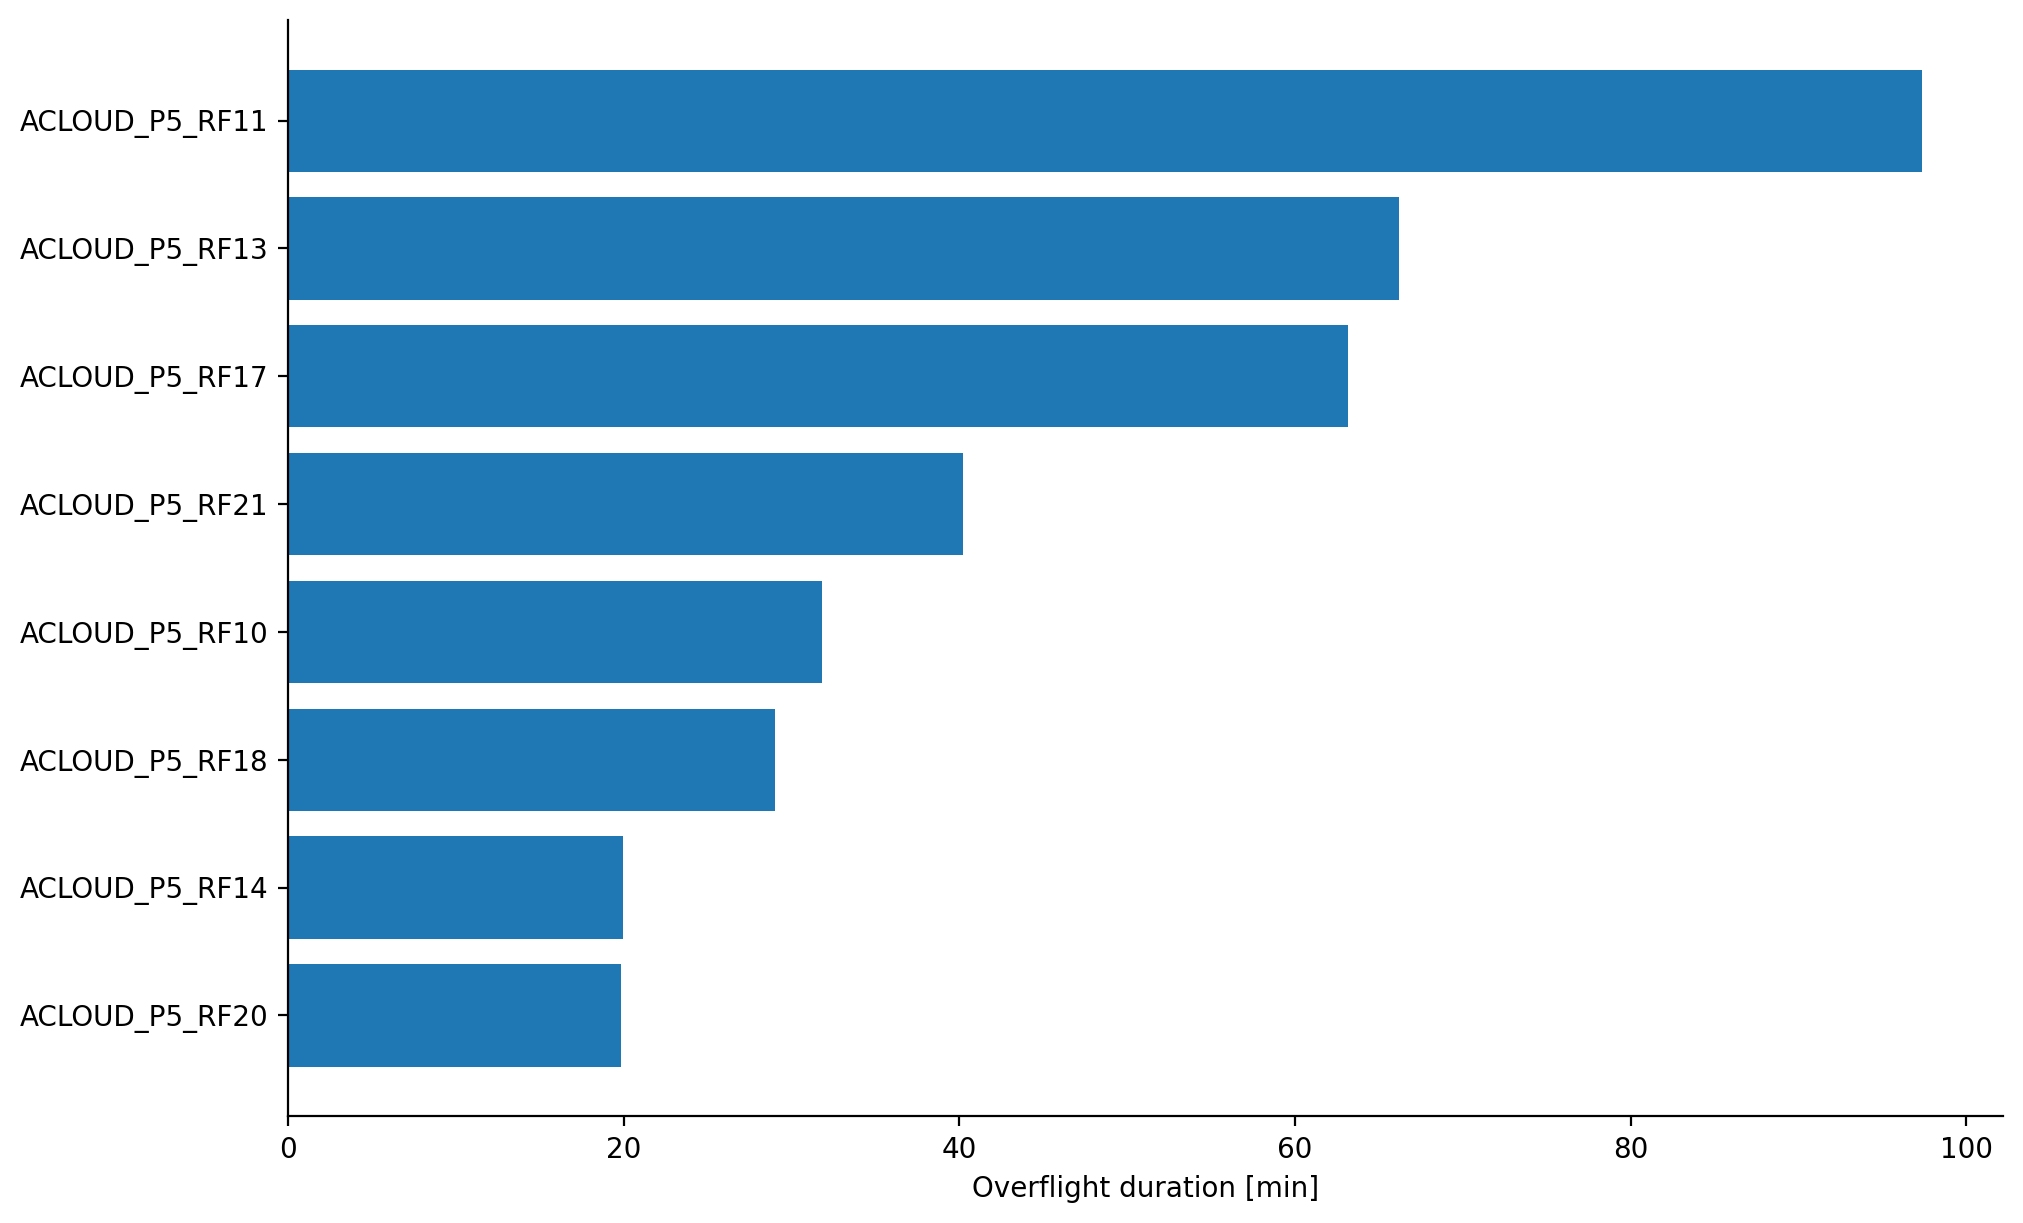

In [12]:
fig, ax = plt.subplots()
ix = np.argsort(times_polarstern)
ax.barh(flights_polarstern[ix], times_polarstern[ix])
ax.set_xlabel('Overflight duration [min]')
plt.show()

## Vertical cross section of overflights
Using the altitude information stored in the GPS-INS dataset, we can plot a vertical cross section of the overflights as function of distance to Polarstern.

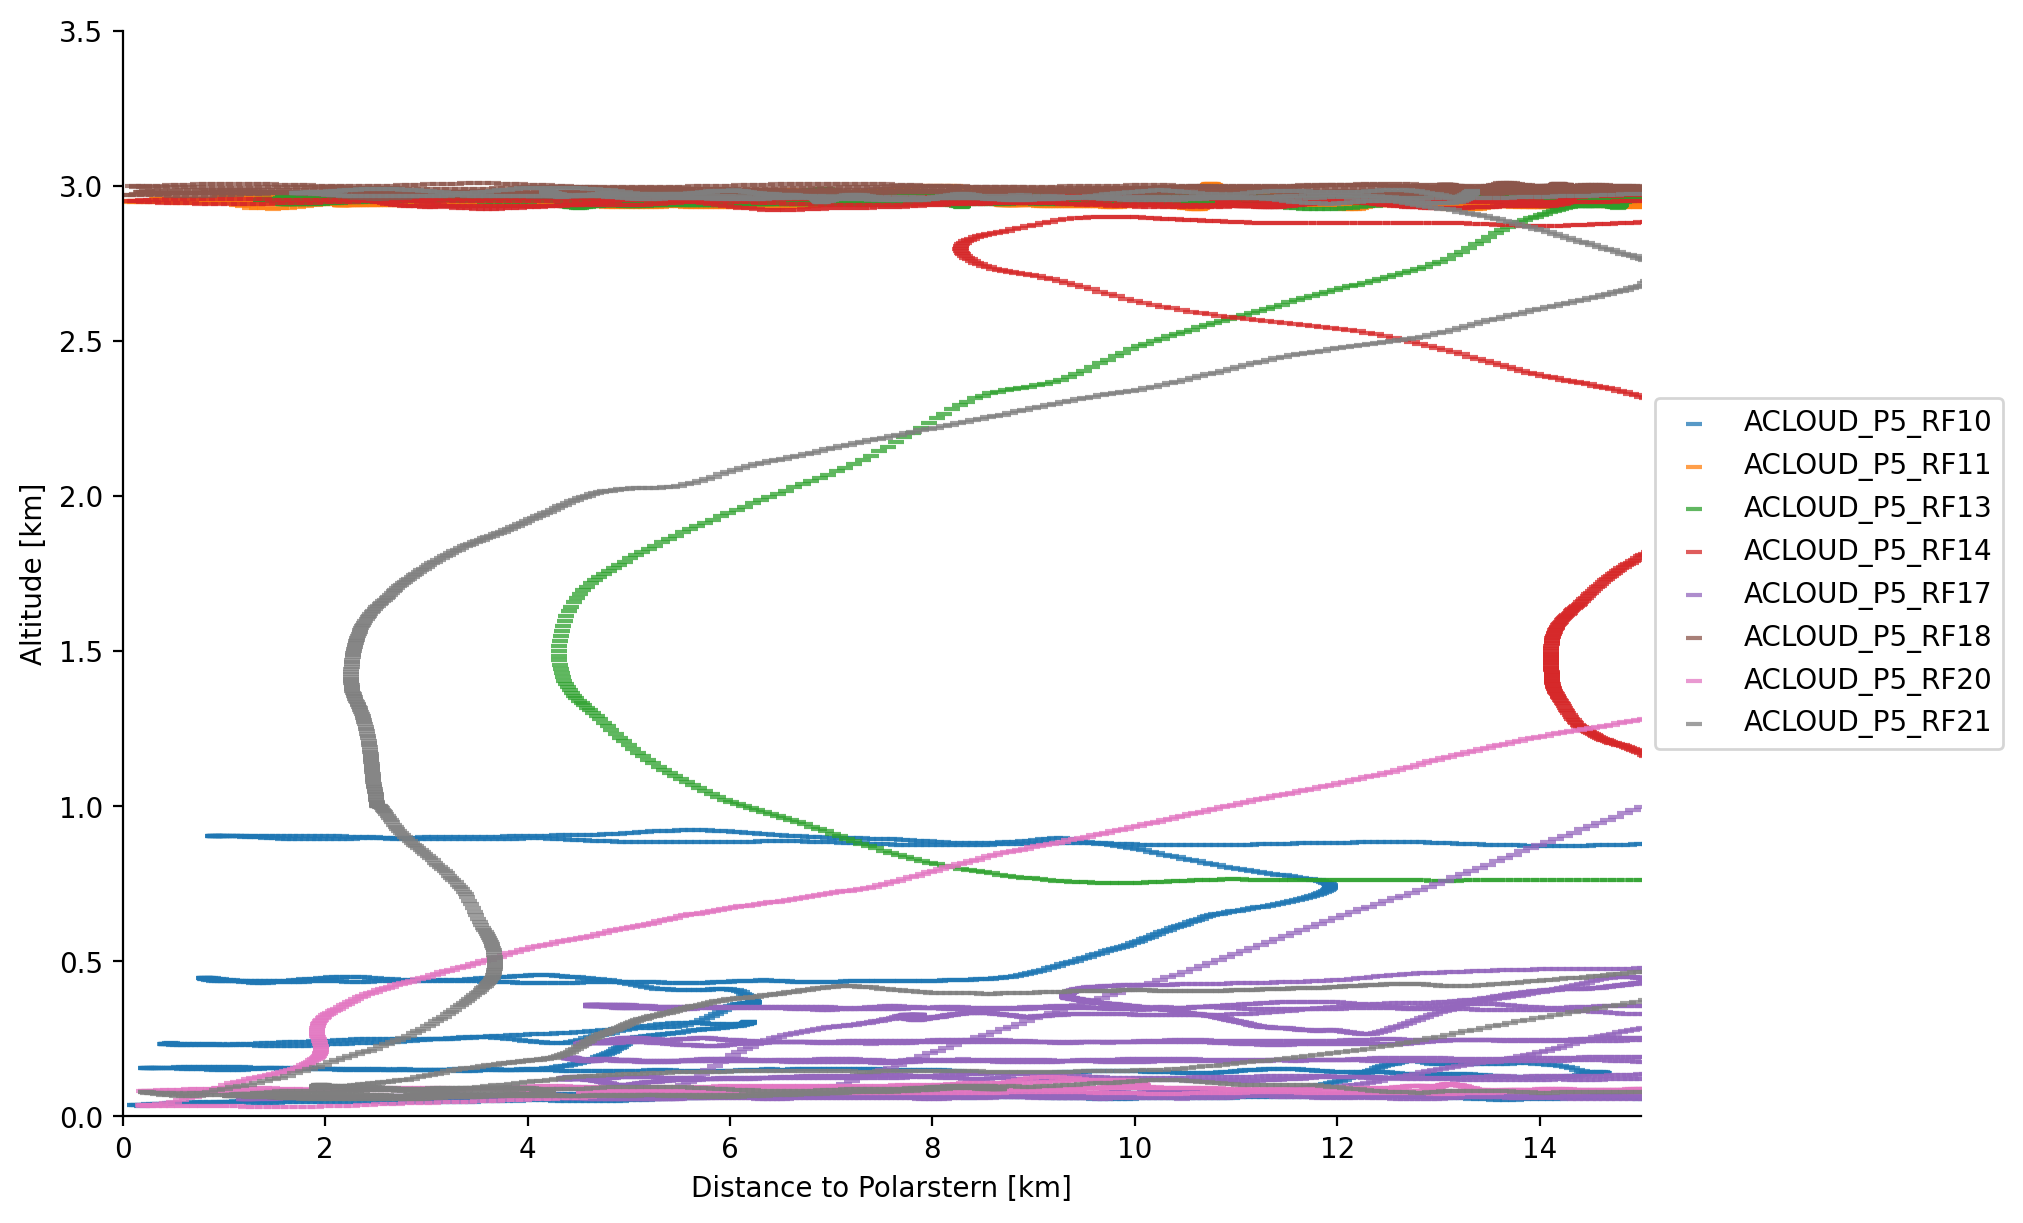

In [13]:
fig, ax = plt.subplots(1, 1)

kwargs = dict(marker='_', alpha=0.75)

for flight_id, flight in meta['ACLOUD']['P5'].items():
    
    # skip dates before and after polarstern cruise
    if flight['date'] not in dates:
        continue
    
    # read gps data of flight
    ds_gps = cat['ACLOUD']['P5']['GPS_INS'][flight_id].to_dask()
    
    # calculate distance to Polarstern
    ds_dist = dist2polarstern(ds_gps, ds_pol.sel(time=ds_gps.time))
    
    if ds_dist['dist'].min() < 15:
        
        ax.scatter(ds_dist['dist'], ds_gps['alt'].sel(time=ds_dist.time)*1e-3, label=flight_id,
                   **kwargs)

ax.set_xlim(0, 15)
ax.set_ylim(0, 3.5)

ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Distance to Polarstern [km]')

ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

## Combining both tracks on a map
Now we want to combine the Polarstern and Polar5 track on a map for a given research flight.

In [14]:
# we select the research flight with the longest time near Polarstern
flight_id = 'ACLOUD_P5_RF11'

The position of Polarstern and Polar5 is marked with a red and blue circle, respectively. Additionally, both tracks are shown by the respective colors. Select the desired time step by moving the slider (0 = takeoff, last value = landing).

In [15]:
def update_position(i):
    """
    Update the position of the location of Polarstern and the aircraft
    on the map using the input from the slider
    """
    
    t = ds_gps.time[i]
    print(f'Time: {str(t.time.values)}')
    loc_gps.location = np.stack([ds_gps.lat.sel(time=t).values,
                                 ds_gps.lon.sel(time=t).values]).tolist()

    loc_pol.location = np.stack([ds_pol.lat.sel(time=t).values, 
                                 ds_pol.lon.sel(time=t).values]).tolist()


# read gps data of research flight
ds_gps = cat['ACLOUD']['P5']['GPS_INS'][flight_id].to_dask()

# create map
m = ipyleaflet.Map(basemap=ipyleaflet.basemap_to_tiles(
    ipyleaflet.basemaps.NASAGIBS.ModisTerraTrueColorCR, str(meta['ACLOUD']['P5'][flight_id]['date'])),
    center=(80, 10),
    zoom=4,
    scroll_wheel_zoom=True)

# plot polarstern track of the same day
ds_pol_reduced = simplify_dataset(ds_pol.sel(time=str(meta['ACLOUD']['P5'][flight_id]['date'])), tolerance=1e-5)
track_pol = ipyleaflet.Polyline(
    locations=np.stack([ds_pol_reduced.lat.values, 
                        ds_pol_reduced.lon.values], axis=1).tolist(), 
    fill=False,
    color='red',
    weight=2,
    name='Polarstern')
m.add_layer(track_pol)

# plot polar5 flight track of research flight
ds_gps = cat['ACLOUD']['P5']['GPS_INS'][flight_id].to_dask()
ds_gps = ds_gps.sel(time=slice(meta['ACLOUD']['P5'][flight_id]['takeoff'], meta['ACLOUD']['P5'][flight_id]['landing']))
ds_gps_reduced = simplify_dataset(ds_gps, tolerance=1e-5)
track_aircraft = ipyleaflet.Polyline(
    locations=np.stack([ds_gps_reduced.lat.values, 
                        ds_gps_reduced.lon.values], axis=1).tolist(),
    fill=False,
    color='blue',
    weight=2,
    name='Polar5',
)

m.add_layer(track_aircraft)

# add location of Polarstern and aircraft at certain time
t = ds_gps.time[0]
loc_gps = ipyleaflet.CircleMarker(
    location=np.stack([ds_gps.lat.sel(time=t).values, 
                        ds_gps.lon.sel(time=t).values]).tolist(),
    radius=5,
    color='blue',
    fill_color='blue',
    name='Polar5 position'
)

m.add_layer(loc_gps)

loc_pol = ipyleaflet.CircleMarker(
    location=np.stack([ds_pol.lat.sel(time=t).values, 
                       ds_pol.lon.sel(time=t).values]).tolist(),
    radius=5,
    color='red',
    fill_color='red',
    name='Polarstern position',
)

m.add_layer(loc_pol)

m.add_control(ipyleaflet.ScaleControl())
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())

interact(update_position, i=widgets.IntSlider(min=0, max=len(ds_gps.time)-1, step=1,
                                              layout=Layout(width='500px')))

display(m)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=19355), Output()),…

Map(center=[80, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…